In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers, utils
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

- train_data : 기사 내용. 리스트를 담고있는 리스트. 하위 리스트는 숫자를 담고있는데 어휘사전에서 해당하는 인덱스의 단어를 가리킨다.
- train_labels : 해당 기사의 주제

In [9]:
# 문제 2-1: reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다.
# [[YOUR CODE]]

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000) # 상위 10000까지만 로드

train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels,
                                                                  test_size=0.25,
                                                                  shuffle=True,
                                                                  random_state=123)



# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력합니다.
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(set(train_labels)))

6736
2246
2246
46


In [10]:
# 문제 2-2: 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다.
def one_hot_encoding(data, dim=10000):
  result = np.zeros((len(data), dim)) # 행 : data의 개수만큼, 열 dim = 10000개만큼 0으로 채운 행렬 생성
  for i, d in enumerate(data): # data안의 요소(d)를 순회한다. i는 d의 인덱스
    result[i,d] = 1. # resudata=lts(0행렬)의 [i,d]번째에 1을 넣는다
  return result
  # [[YOUR CODE]]

train_data = one_hot_encoding(train_data)
val_data = one_hot_encoding(val_data)
test_data = one_hot_encoding(test_data)


In [11]:
# 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.
# [[YOUR CODE]]
train_labels_cat = utils.to_categorical(train_labels)
val_labels_cat = utils.to_categorical(val_labels)
test_labels_cat = utils.to_categorical(test_labels)

### 모델 구성 및 컴파일
---
BatchNormalization과 Dropout을 적용하여 빠르게 학습하면서 과대적합을 방지하고, 46개의 뉴스 주제를 분류하는 딥러닝 모델을 구성합니다.

In [12]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
# [[YOUR CODE]]
model = models.Sequential()
model.add(layers.Dense(128, input_shape=(10000,), name='input'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(64,  name='hidden'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(46, activation='softmax', name='output'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 128)               1280128   
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 128)               0         
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 hidden (Dense)              (None, 64)                8256      
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                     

In [13]:
# train_data.shape, train_labels.shape,train_labels_cat.shape, val_data.shape, val_labels.shape,val_labels_cat.shape
train_data.shape, train_labels_cat.shape

((6736, 10000), (6736, 46))

In [14]:
# 필요한 콜백 정의하기
check_point_cb = callbacks.ModelCheckpoint('reuters_4.h5', save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=10, monitor='val_loss',
                                  restore_best_weights=True)

# 훈련 내역을 history에 저장
history = model.fit(train_data,train_labels_cat,
                    epochs=30,
                    batch_size=512,
                    validation_data=(val_data, val_labels_cat),
                    callbacks=[check_point_cb,early_stopping_cb])

# 1 : loss: 0.0746 - accuracy: 0.9672 - val_loss: 1.2110 - val_accuracy: 0.7916 # 기본
# 2 : loss: 0.2630 - accuracy: 0.9339 - val_loss: 0.9960 - val_accuracy: 0.7930 # 드롭아웃 0.2 -> 0.5 (두개 레이어에 모두)
# 3 : loss: 0.1139 - accuracy: 0.9641 - val_loss: 0.9817 - val_accuracy: 0.7930 # 레이어 한단위 제거 (Dense-Batch-Activ-Drop)


Epoch 1/30
14/14 [==============================] - 2s 72ms/step - loss: 2.7890 - accuracy: 0.3979 - val_loss: 3.3686 - val_accuracy: 0.6256
Epoch 2/30
14/14 [==============================] - 0s 36ms/step - loss: 1.9097 - accuracy: 0.6167 - val_loss: 3.1041 - val_accuracy: 0.6723
Epoch 3/30
14/14 [==============================] - 1s 37ms/step - loss: 1.5508 - accuracy: 0.6835 - val_loss: 2.8504 - val_accuracy: 0.6745
Epoch 4/30
14/14 [==============================] - 0s 35ms/step - loss: 1.3465 - accuracy: 0.7113 - val_loss: 2.6573 - val_accuracy: 0.6888
Epoch 5/30
14/14 [==============================] - 1s 37ms/step - loss: 1.1810 - accuracy: 0.7380 - val_loss: 2.4008 - val_accuracy: 0.6897
Epoch 6/30
14/14 [==============================] - 0s 36ms/step - loss: 1.0646 - accuracy: 0.7589 - val_loss: 2.1771 - val_accuracy: 0.7035
Epoch 7/30
14/14 [==============================] - 1s 41ms/step - loss: 0.9677 - accuracy: 0.7739 - val_loss: 1.9797 - val_accuracy: 0.7164
Epoch 8/30
14

/var/folders/96/sm2p62h1023c4ytkjcyhc9x40000gn/T/ipykernel_2638/98960745.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


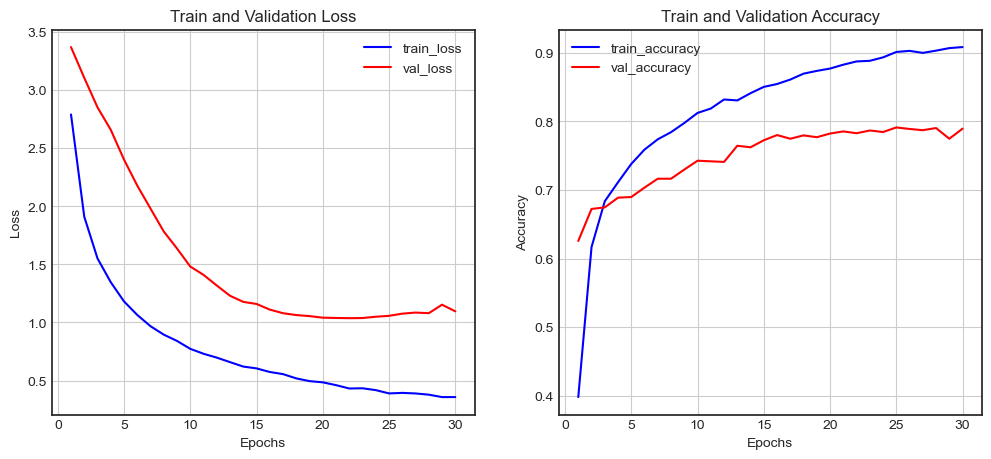

In [15]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()


### 모델 평가 및 예측
---
테스트 데이터셋으로 모델 평가하기


In [16]:
# 평가
model.evaluate(test_data, test_labels_cat)

# loss: 1.0742 - accuracy: 0.7907

71/71 [==============================] - 0s 2ms/step - loss: 1.0811 - accuracy: 0.7894


[1.0810692310333252, 0.7894033789634705]

In [17]:
# 예측
pred = model.predict(train_data)
print(pred.shape)

211/211 [==============================] - 1s 2ms/step
(6736, 46)
